In [35]:
#import the basic libraries for exploration 
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns 



#import the dataset
data = pd.read_csv('F:/Data science/projects/data_analysis/Health_care_project/data/healthcare_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

In [13]:
#explore the numerical variables 
numerical_vals = ['Age', 'Billing Amount']

#describe the data at first glance 
data[numerical_vals].describe()

#from the view we have a negative Minimum value in Billing amount

,Age,Billing Amount
count,55500.000000,55500.000000
mean,51.539459,25539.316097
std,19.602454,14211.454431
min,13.000000,-2008.492140
25%,35.000000,13241.224652
50%,52.000000,25538.069376
75%,68.000000,37820.508436
max,89.000000,52764.276736


In [21]:
data.select_dtypes(object).head()

,Name,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,Urgent,2022-10-09,Penicillin,Abnormal


In [52]:
# create a function that creates a finalized dataset that cleans the data 

def wrangle(df):
    
    #drop the columns of doctor name  and hospital 
    df = df.drop(columns=['Name', 'Doctor', 'Hospital'])

    #create a new columns that calculates the duration of hospital stay 
    df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])
    df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])
    df['hospital_stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.total_seconds() /86400

    #drop the date of admission and Discharge date columns 
    df.drop(columns=['Date of Admission', 'Discharge Date', 'Room Number'], inplace=True)

    #Map the following data into specific encoders 
    df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
    df['Admission Type'] = df['Admission Type'].map({'Urgent': 0, 'Emergent':1, 'Elective': 2})
    df.dropna(inplace=True)
    

    return df

In [53]:
df = wrangle(data)
df.head()

,Age,Gender,Blood Type,Medical Condition,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results,hospital_stay
0,30,1,B-,Cancer,Blue Cross,18856.281306,0.0,Paracetamol,Normal,2.0
3,28,0,O+,Diabetes,Medicare,37909.782410,2.0,Ibuprofen,Abnormal,30.0
4,43,0,AB+,Cancer,Aetna,14238.317814,0.0,Penicillin,Abnormal,20.0
5,36,1,A+,Asthma,UnitedHealthcare,48145.110951,0.0,Ibuprofen,Normal,4.0
8,82,1,AB+,Asthma,Cigna,50119.222792,2.0,Aspirin,Abnormal,13.0


In [55]:
df.shape


(37231, 10)

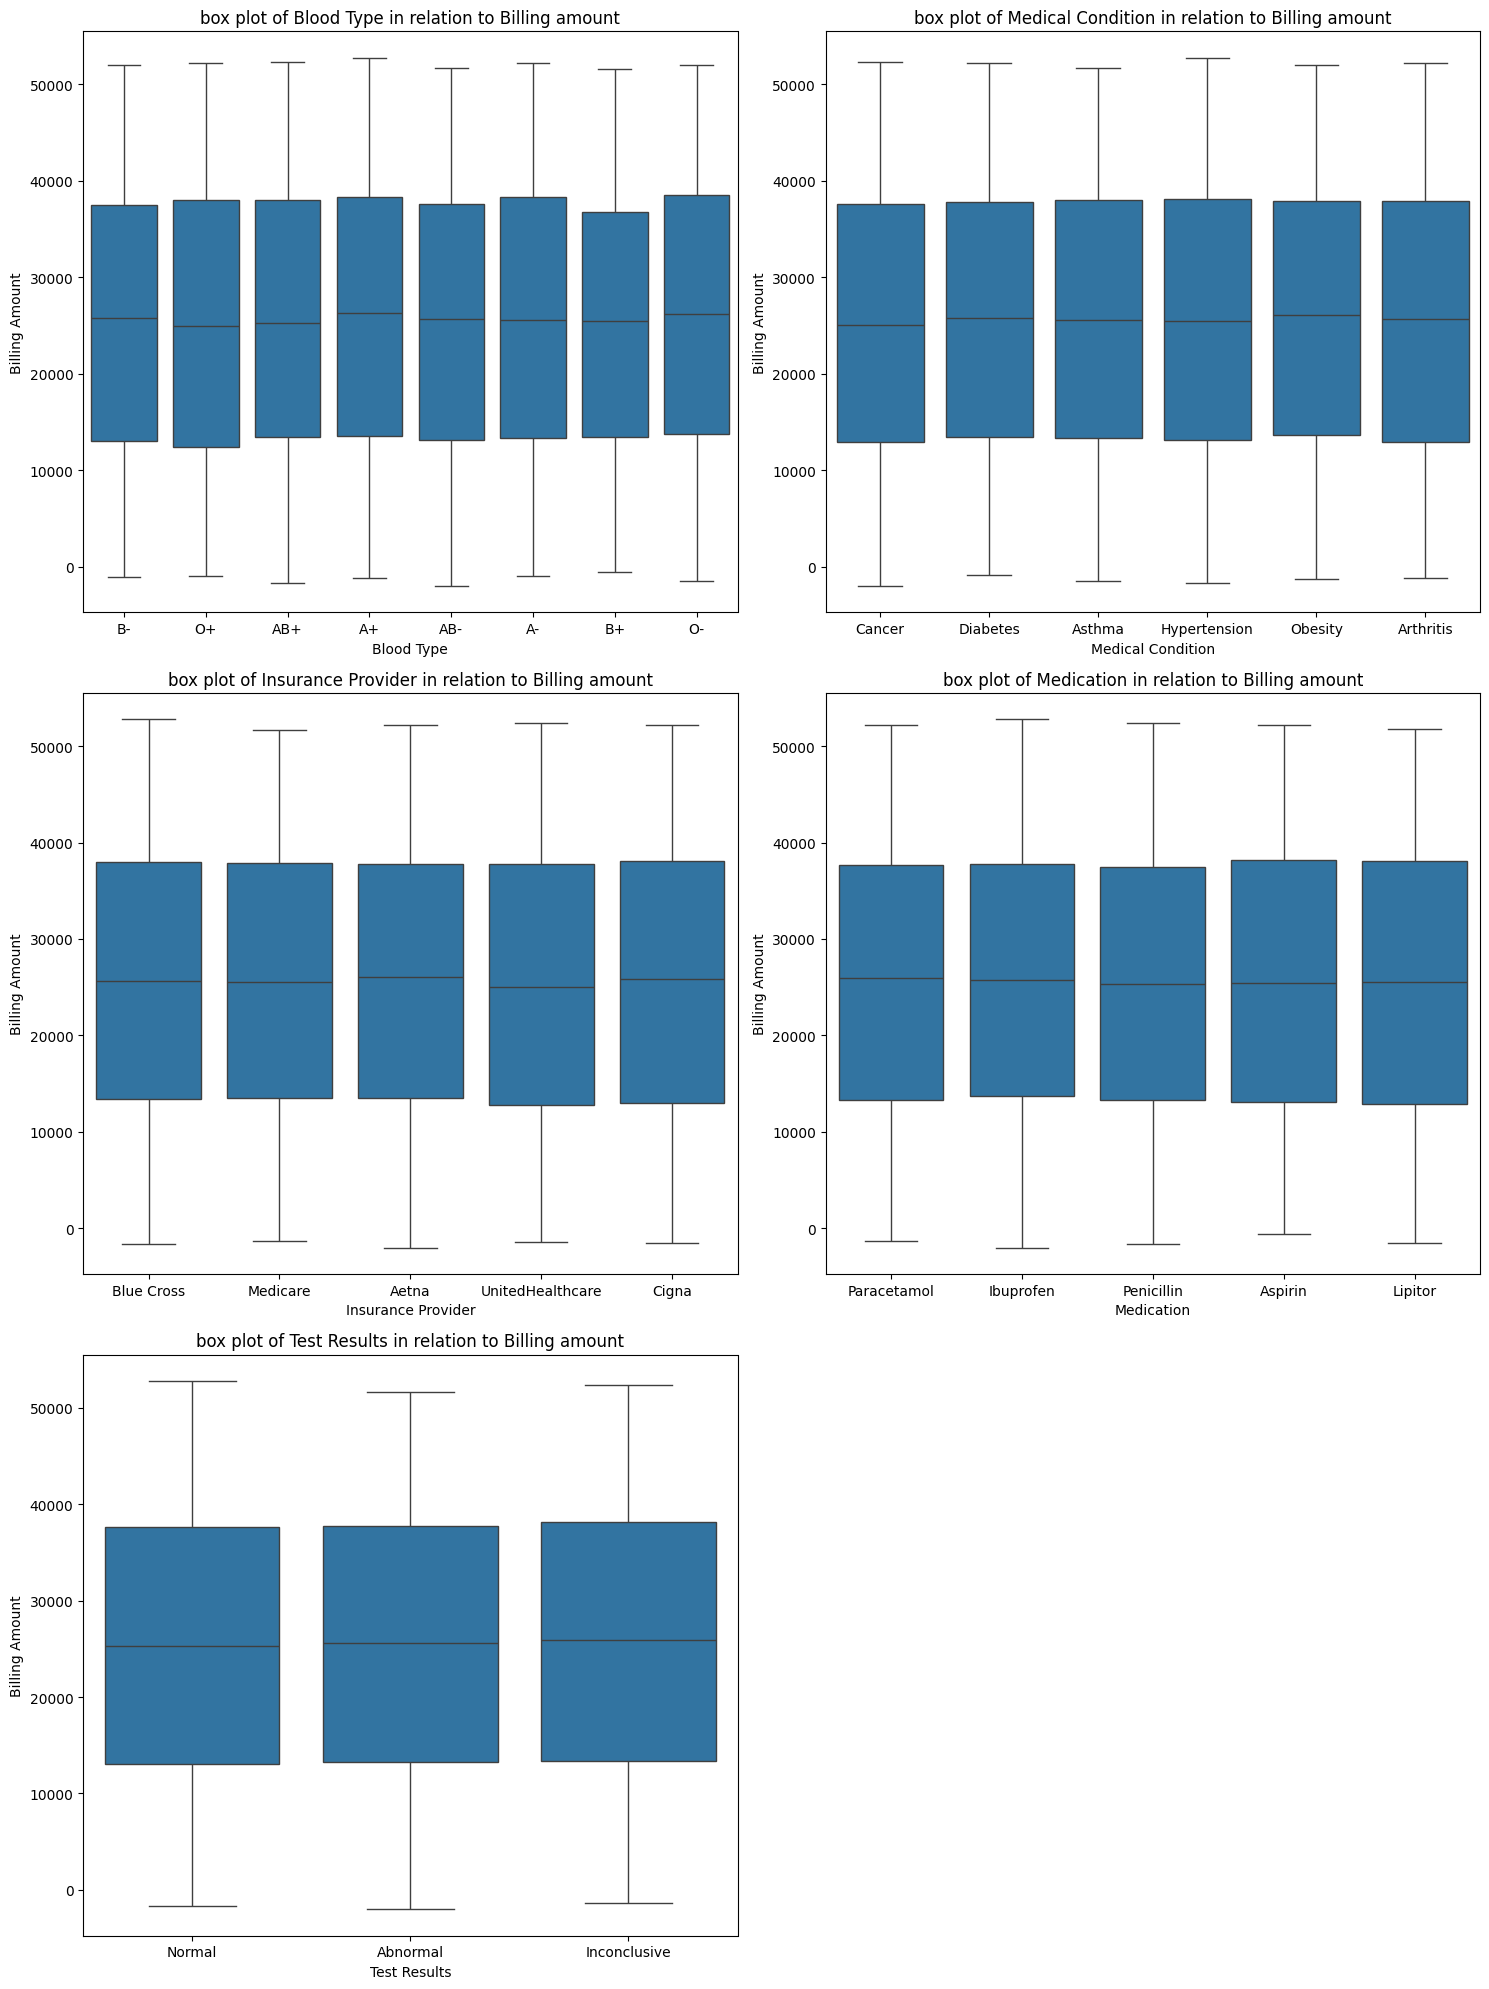

In [61]:
#lets firs explore the relation between categorical variables and Hospital bill
cat_val = df.select_dtypes(object).columns.tolist()
plt.figure(figsize=(15,20))
for i, name in enumerate(cat_val):
    
    plt.subplot(3,2, i+1)
    sns.boxplot(x=name, y='Billing Amount', data=df)
    plt.title(f'box plot of {name} in relation to Billing amount')
    plt.tight_layout()
plt.show()

In [65]:
cat_val

['Blood Type',
 'Medical Condition',
 'Insurance Provider',
 'Medication',
 'Test Results']

In [67]:
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split

encoder = OneHotEncoder(use_cat_names=True)

#split into Features and target variables 
X = df.drop(columns='Billing Amount')
y = df['Billing Amount']

#split into training and testing data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#X_train encoded 
XT_train = encoder.fit_transform(X_train)
XT_test = encoder.transform(X_test)

#print the shapes 
XT_train.shape



(29784, 31)

In [70]:
#lets instantiate basic models and see how they work
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import time
from sklearn.metrics import mean_absolute_error, r2_score


models = {
    'Linear_regression': LinearRegression(),
    'Random_regressor': RandomForestRegressor(),
    'SVM': SVR(),
    'Nearest_neighbors': KNeighborsRegressor()
}

results = []

for name, model in models.items():
    stat = time.time()
    model.fit(XT_train, y_train)
    #make predictions on test and 
    y_pred_train = model.predict(XT_train)
    y_pred_test = model.predict(XT_test)
    duration = time.time() - stat

    #make scores 
    score_train = model.score(XT_train, y_train)
    score_test = model.score(XT_test, y_test)

    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    #root mean squared error
    rmse_train = np.sqrt(mae_train)
    rmse_test = np.sqrt(mae_test)

    #r2 score 
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    #append the results 
    results.append({
        'model': name,
        'score_train': score_train,
        'score_test': score_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'training_time': duration
    })


results_df = pd.DataFrame(results)
results_df.head()




,model,score_train,score_test,mae_train,mae_test,rmse_train,rmse_test,r2_train,r2_test,training_time
0,Linear_regression,0.001034,-0.001089,12273.856067,12458.680380,110.787436,111.618459,0.001034,-0.001089,0.100157
1,Random_regressor,0.866353,0.045326,4342.022394,11916.258212,65.894024,109.161615,0.866353,0.045326,18.872108
2,SVM,-0.000013,-0.000456,12283.046266,12456.394671,110.828905,111.608220,-0.000013,-0.000456,208.540206
3,Nearest_neighbors,0.221337,-0.158342,10478.887299,13013.769430,102.366436,114.077909,0.221337,-0.158342,3.022456
